In [6]:
import numpy as np
import math
import cython
import pandas as pd
import multiprocessing as mp
import argparse
import deepdish
import matplotlib.pyplot as plt


import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

In [7]:
PWM_SCHEMA = ["MOTIF_NAME", "MOTIF_PWM_FWD", "1", "2", "3", "4", "5", "6", "7", "8"]

motifs_to_pwm="/mnt/lab_data2/anusri/chrombpnet/src/evaluation/marginal_footprints/k562_all_motifs.tsv"

pwm_df = pd.read_csv(motifs_to_pwm, sep='\t',names=PWM_SCHEMA)


motif_widths={}
motif_names={}

for i,r in pwm_df.iterrows():
    motif_widths[r["MOTIF_NAME"]] = len(r["MOTIF_PWM_FWD"])

for i,r in pwm_df.iterrows():
    if int(r["MOTIF_NAME"].split("_")[-1]) <= 20:
        motif_names[r["MOTIF_NAME"]] = r["1"]
    if int(r["MOTIF_NAME"].split("_")[-1]) == 21:
        motif_names[r["MOTIF_NAME"]] = "ETV4-ETV4"
    if int(r["MOTIF_NAME"].split("_")[-1]) == 22:
        motif_names[r["MOTIF_NAME"]] = "ETV4-KLF"



In [8]:
ignore_motifs = ["K562_COUNTS_metacluster_0_pattern_"+str(idx) for idx in [9,18, 21,22, 23, 24, 25, 26, 27, 28, 29] ]

In [9]:
ignore_motifs

['K562_COUNTS_metacluster_0_pattern_9',
 'K562_COUNTS_metacluster_0_pattern_18',
 'K562_COUNTS_metacluster_0_pattern_21',
 'K562_COUNTS_metacluster_0_pattern_22',
 'K562_COUNTS_metacluster_0_pattern_23',
 'K562_COUNTS_metacluster_0_pattern_24',
 'K562_COUNTS_metacluster_0_pattern_25',
 'K562_COUNTS_metacluster_0_pattern_26',
 'K562_COUNTS_metacluster_0_pattern_27',
 'K562_COUNTS_metacluster_0_pattern_28',
 'K562_COUNTS_metacluster_0_pattern_29']

In [10]:
k562_atac_scores = "/oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/ATAC/K562/footprints/K562_k562_only_footprints.h5"
k562_dnase_scores = "/oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/DNASE/K562/footprints/K562_k562_only_footprints.h5"
scores_atac = deepdish.io.load(k562_atac_scores)
control_fotprint_atac = scores_atac["control"][0]
scores_dnase = deepdish.io.load(k562_dnase_scores)
control_fotprint_dnase = scores_dnase["control"][0]


In [23]:
import scipy.signal
def get_footprint_characteristics(motif_width, corrected_footprint_1, nomotif_corrected_footprint_1, title, output_prefix, motif_name, widths, heights):
    
    fc_change = (corrected_footprint_1/np.sum(corrected_footprint_1)) * np.log(np.sum(corrected_footprint_1)/np.sum(nomotif_corrected_footprint_1))

    #fc_change = (corrected_footprint_1/np.sum(corrected_footprint_1)) 
    #* np.log(np.sum(corrected_footprint_1)/np.sum(nomotif_corrected_footprint_1))

    #print(np.log(np.sum(corrected_footprint_1)/np.sum(nomotif_corrected_footprint_1)))
    #fc_change = corrected_footprint_1/np.sum(corrected_footprint_1)
    
    #fc_change = np.log(corrected_footprint_1) - np.log(nomotif_corrected_footprint_1)
    smoothed_fc = np.convolve(fc_change, np.ones(6)/6, mode='same')
    peaks,_ = scipy.signal.find_peaks(smoothed_fc)

    proms = scipy.signal.peak_prominences(smoothed_fc,peaks)[0]
    indicies = np.argsort(proms)[::-1]
    
    motif_half_width = motif_width//4
    right_edge =  None
    left_edge = None
    right_proms = None
    left_proms = None
    
    for idx in indicies:
        if (peaks[idx] > 500+motif_half_width) and (right_edge is None):
            right_edge = peaks[idx] 
            right_proms = smoothed_fc[right_edge]
        if (peaks[idx] < 500-motif_half_width) and (left_edge is None):
            left_edge = peaks[idx]
            left_proms = smoothed_fc[left_edge]

        if (left_edge is not None) and (right_edge is not None):
            break
    

    width = right_edge - left_edge
    height = np.max([smoothed_fc[left_edge],smoothed_fc[right_edge]]) - np.min(smoothed_fc[left_edge:right_edge])
 
    widths[motif_name] = width
    heights[motif_name] = height
        
    #print(proms)
    plt.figure() 
    print(motif_name)
    #print(pwm_df[pwm_df["MOTIF_NAME"]==motif_name]["1"])
    #plt.plot(smoothed_fc)
    #plt.plot([left_edge,right_edge], [smoothed_fc[left_edge],smoothed_fc[right_edge]], "x")
 
    plt.plot(fc_change[400:600])
    plt.plot([left_edge-400,right_edge-400], [left_proms,right_proms], "x")
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Counts',fontsize=18)
    plt.xlabel('motif_wdith+100bp bases around motif insertion',fontsize=18)
    plt.show()
    #plt.savefig("subfigs/footprints_compare/K562_COUNTS_metacluster_0_pattern_16_footprint.pdf", dpi=300)
    
    return widths, heights



K562_COUNTS_metacluster_0_pattern_0


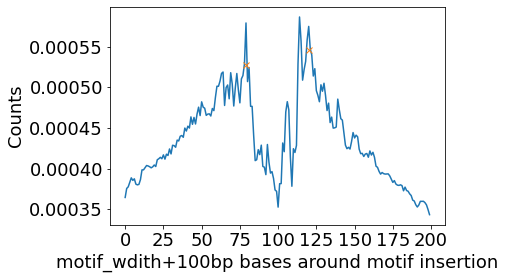

K562_COUNTS_metacluster_0_pattern_1


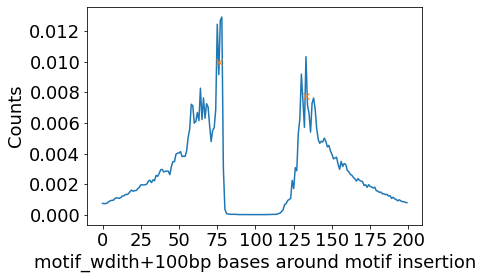

K562_COUNTS_metacluster_0_pattern_10


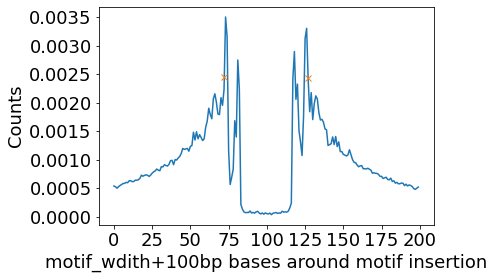

K562_COUNTS_metacluster_0_pattern_11


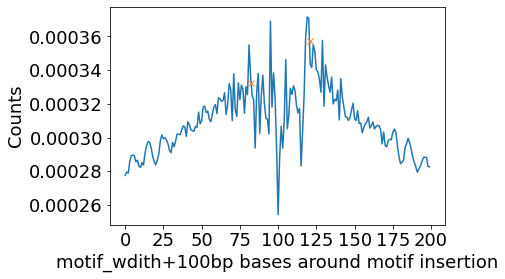

K562_COUNTS_metacluster_0_pattern_12


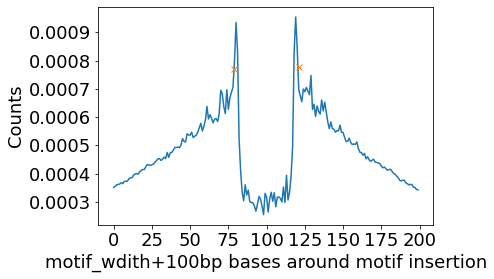

K562_COUNTS_metacluster_0_pattern_13


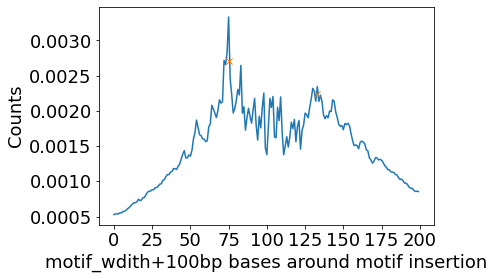

K562_COUNTS_metacluster_0_pattern_14


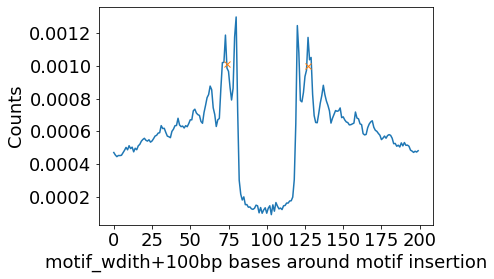

K562_COUNTS_metacluster_0_pattern_15


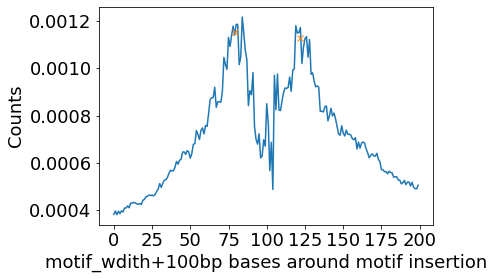

K562_COUNTS_metacluster_0_pattern_16


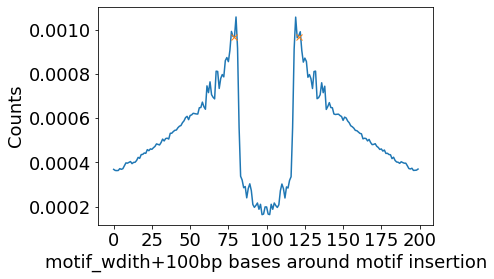

K562_COUNTS_metacluster_0_pattern_17


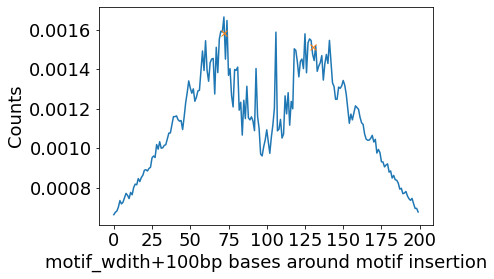

K562_COUNTS_metacluster_0_pattern_19


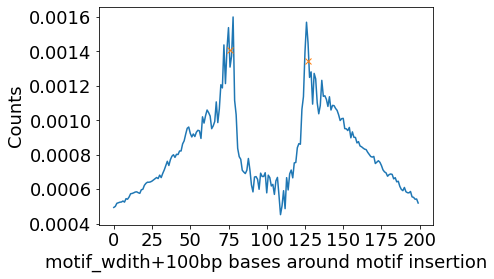

K562_COUNTS_metacluster_0_pattern_2


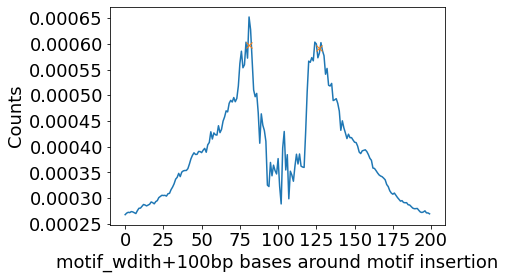

K562_COUNTS_metacluster_0_pattern_20


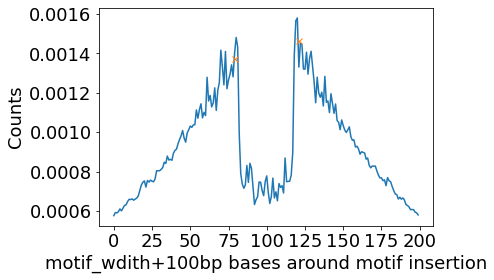

K562_COUNTS_metacluster_0_pattern_3


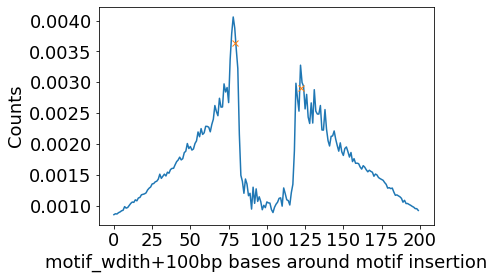

K562_COUNTS_metacluster_0_pattern_4


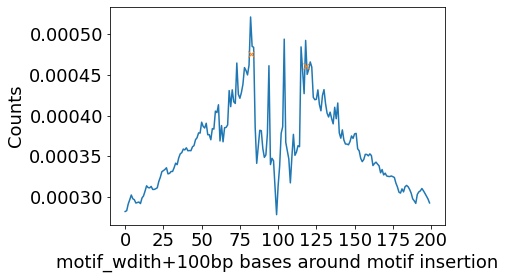

K562_COUNTS_metacluster_0_pattern_5


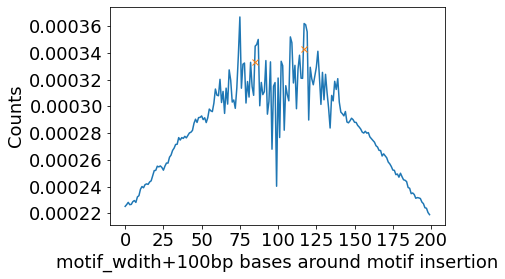

K562_COUNTS_metacluster_0_pattern_6


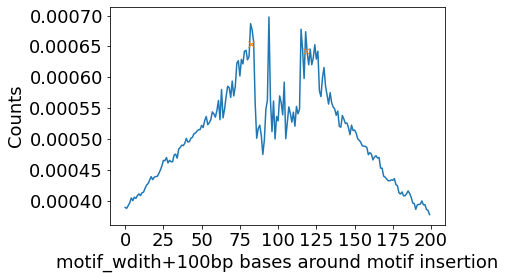

K562_COUNTS_metacluster_0_pattern_7


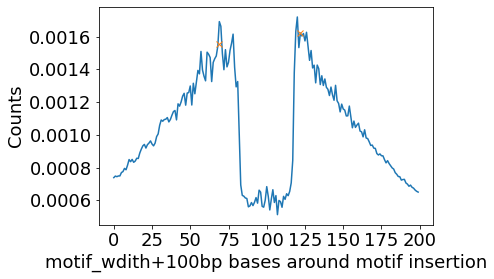

K562_COUNTS_metacluster_0_pattern_8


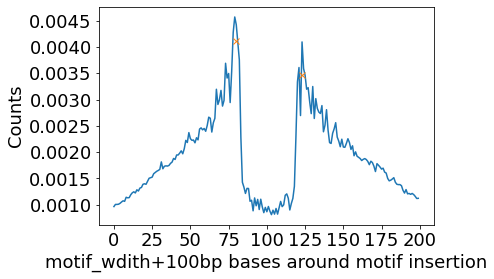

In [24]:
atac_width={}
atac_height={}
#scores_atac.keys()
#for motif in  ["K562_COUNTS_metacluster_0_pattern_16"]:
for motif in  scores_atac.keys():

    if motif=="control":
        continue
        
    if motif in ignore_motifs:
        continue

    motif_footprint = scores_atac[motif][0]
    width = motif_widths[motif]
    atac_width, atac_height = get_footprint_characteristics(width, motif_footprint, control_fotprint_atac, "title", "temp", motif, atac_width, atac_height)


K562_COUNTS_metacluster_0_pattern_0


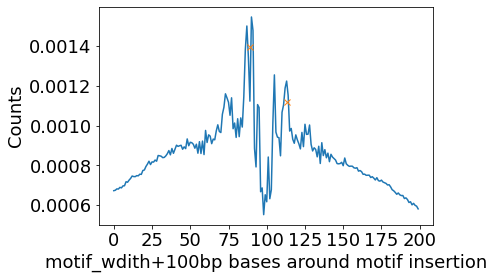

K562_COUNTS_metacluster_0_pattern_1


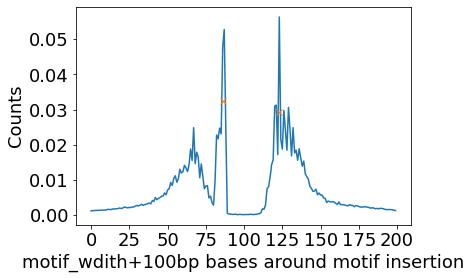

K562_COUNTS_metacluster_0_pattern_10


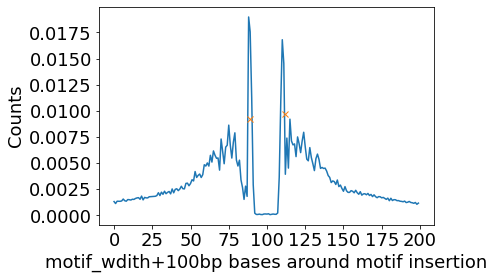

K562_COUNTS_metacluster_0_pattern_11


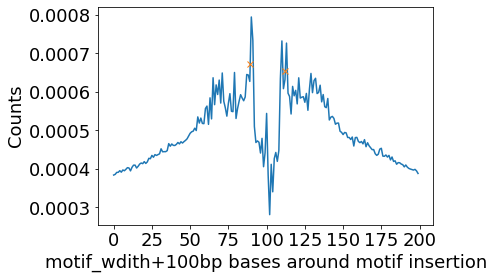

K562_COUNTS_metacluster_0_pattern_12


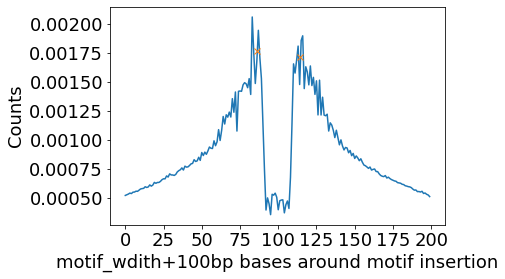

K562_COUNTS_metacluster_0_pattern_13


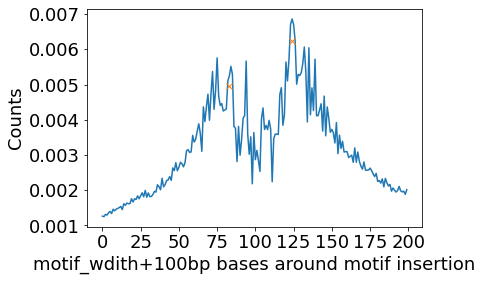

K562_COUNTS_metacluster_0_pattern_14


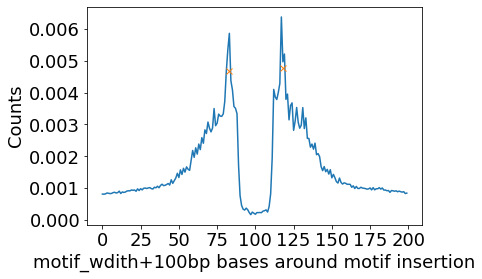

K562_COUNTS_metacluster_0_pattern_15


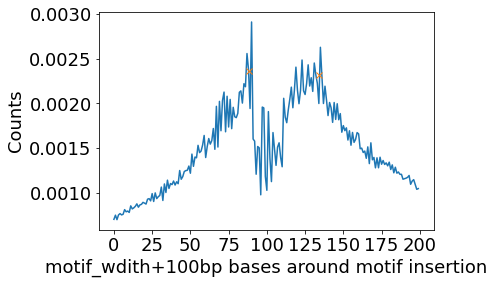

K562_COUNTS_metacluster_0_pattern_16


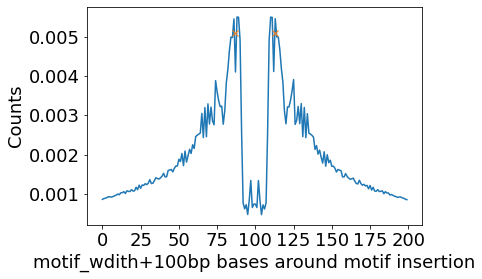

K562_COUNTS_metacluster_0_pattern_17


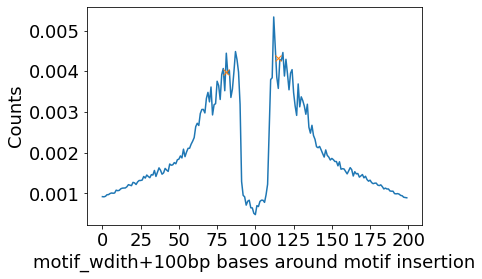

K562_COUNTS_metacluster_0_pattern_19


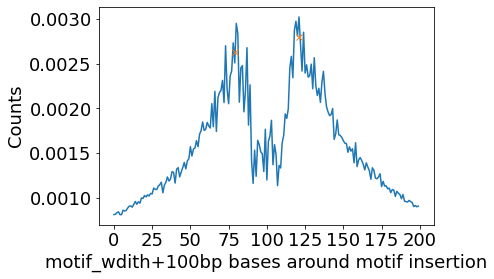

K562_COUNTS_metacluster_0_pattern_2


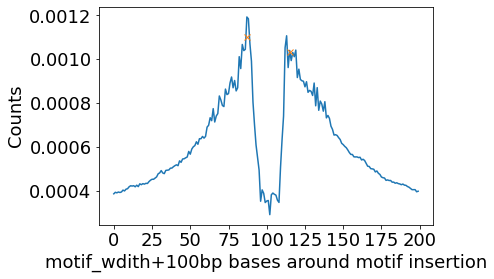

K562_COUNTS_metacluster_0_pattern_20


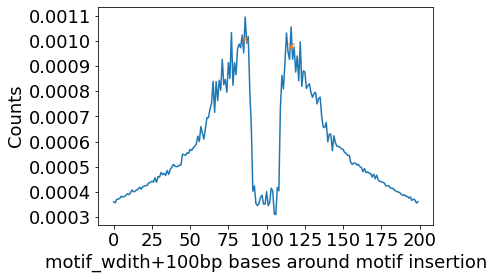

K562_COUNTS_metacluster_0_pattern_3


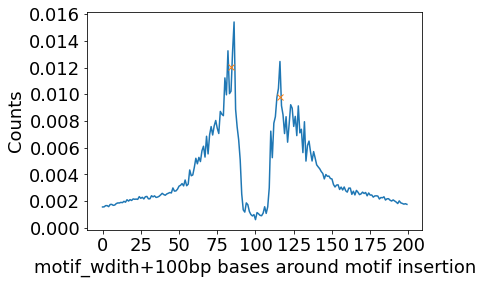

K562_COUNTS_metacluster_0_pattern_4


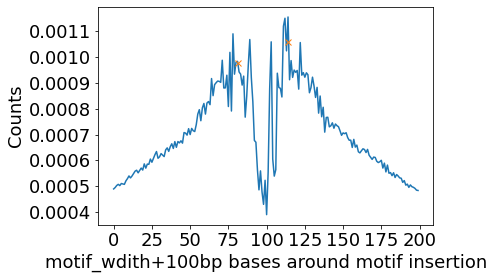

K562_COUNTS_metacluster_0_pattern_5


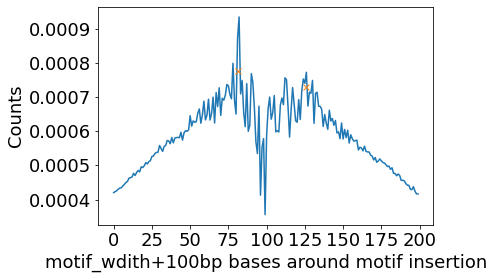

K562_COUNTS_metacluster_0_pattern_6


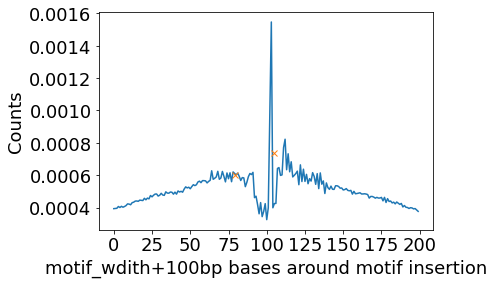

K562_COUNTS_metacluster_0_pattern_7


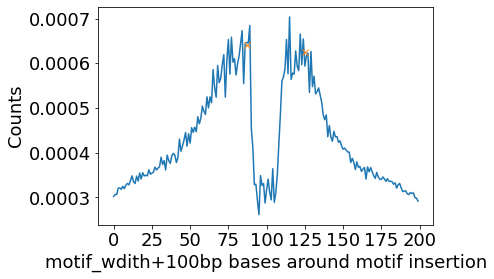

K562_COUNTS_metacluster_0_pattern_8


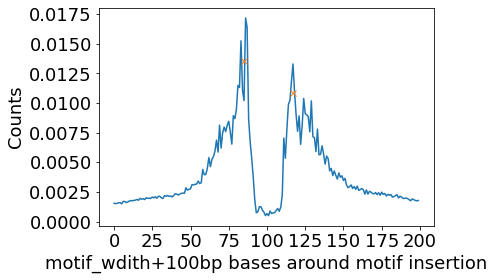

In [25]:
dnase_width={}
dnase_height={}
for motif in  scores_dnase.keys():
    if motif=="control":
        continue
        
    if motif in ignore_motifs:
        continue
        
    motif_footprint = scores_dnase[motif][0]
    width = motif_widths[motif]
    dnase_width, dnase_height = get_footprint_characteristics(width, motif_footprint, control_fotprint_dnase, "title", "temp", motif, dnase_width, dnase_height)


K562_COUNTS_metacluster_0_pattern_0
K562_COUNTS_metacluster_0_pattern_1
K562_COUNTS_metacluster_0_pattern_10
K562_COUNTS_metacluster_0_pattern_11
K562_COUNTS_metacluster_0_pattern_12
K562_COUNTS_metacluster_0_pattern_13
K562_COUNTS_metacluster_0_pattern_14
K562_COUNTS_metacluster_0_pattern_15
K562_COUNTS_metacluster_0_pattern_16
K562_COUNTS_metacluster_0_pattern_17
K562_COUNTS_metacluster_0_pattern_19
K562_COUNTS_metacluster_0_pattern_2
K562_COUNTS_metacluster_0_pattern_20
K562_COUNTS_metacluster_0_pattern_3
K562_COUNTS_metacluster_0_pattern_4
K562_COUNTS_metacluster_0_pattern_5
K562_COUNTS_metacluster_0_pattern_6
K562_COUNTS_metacluster_0_pattern_7
K562_COUNTS_metacluster_0_pattern_8


91

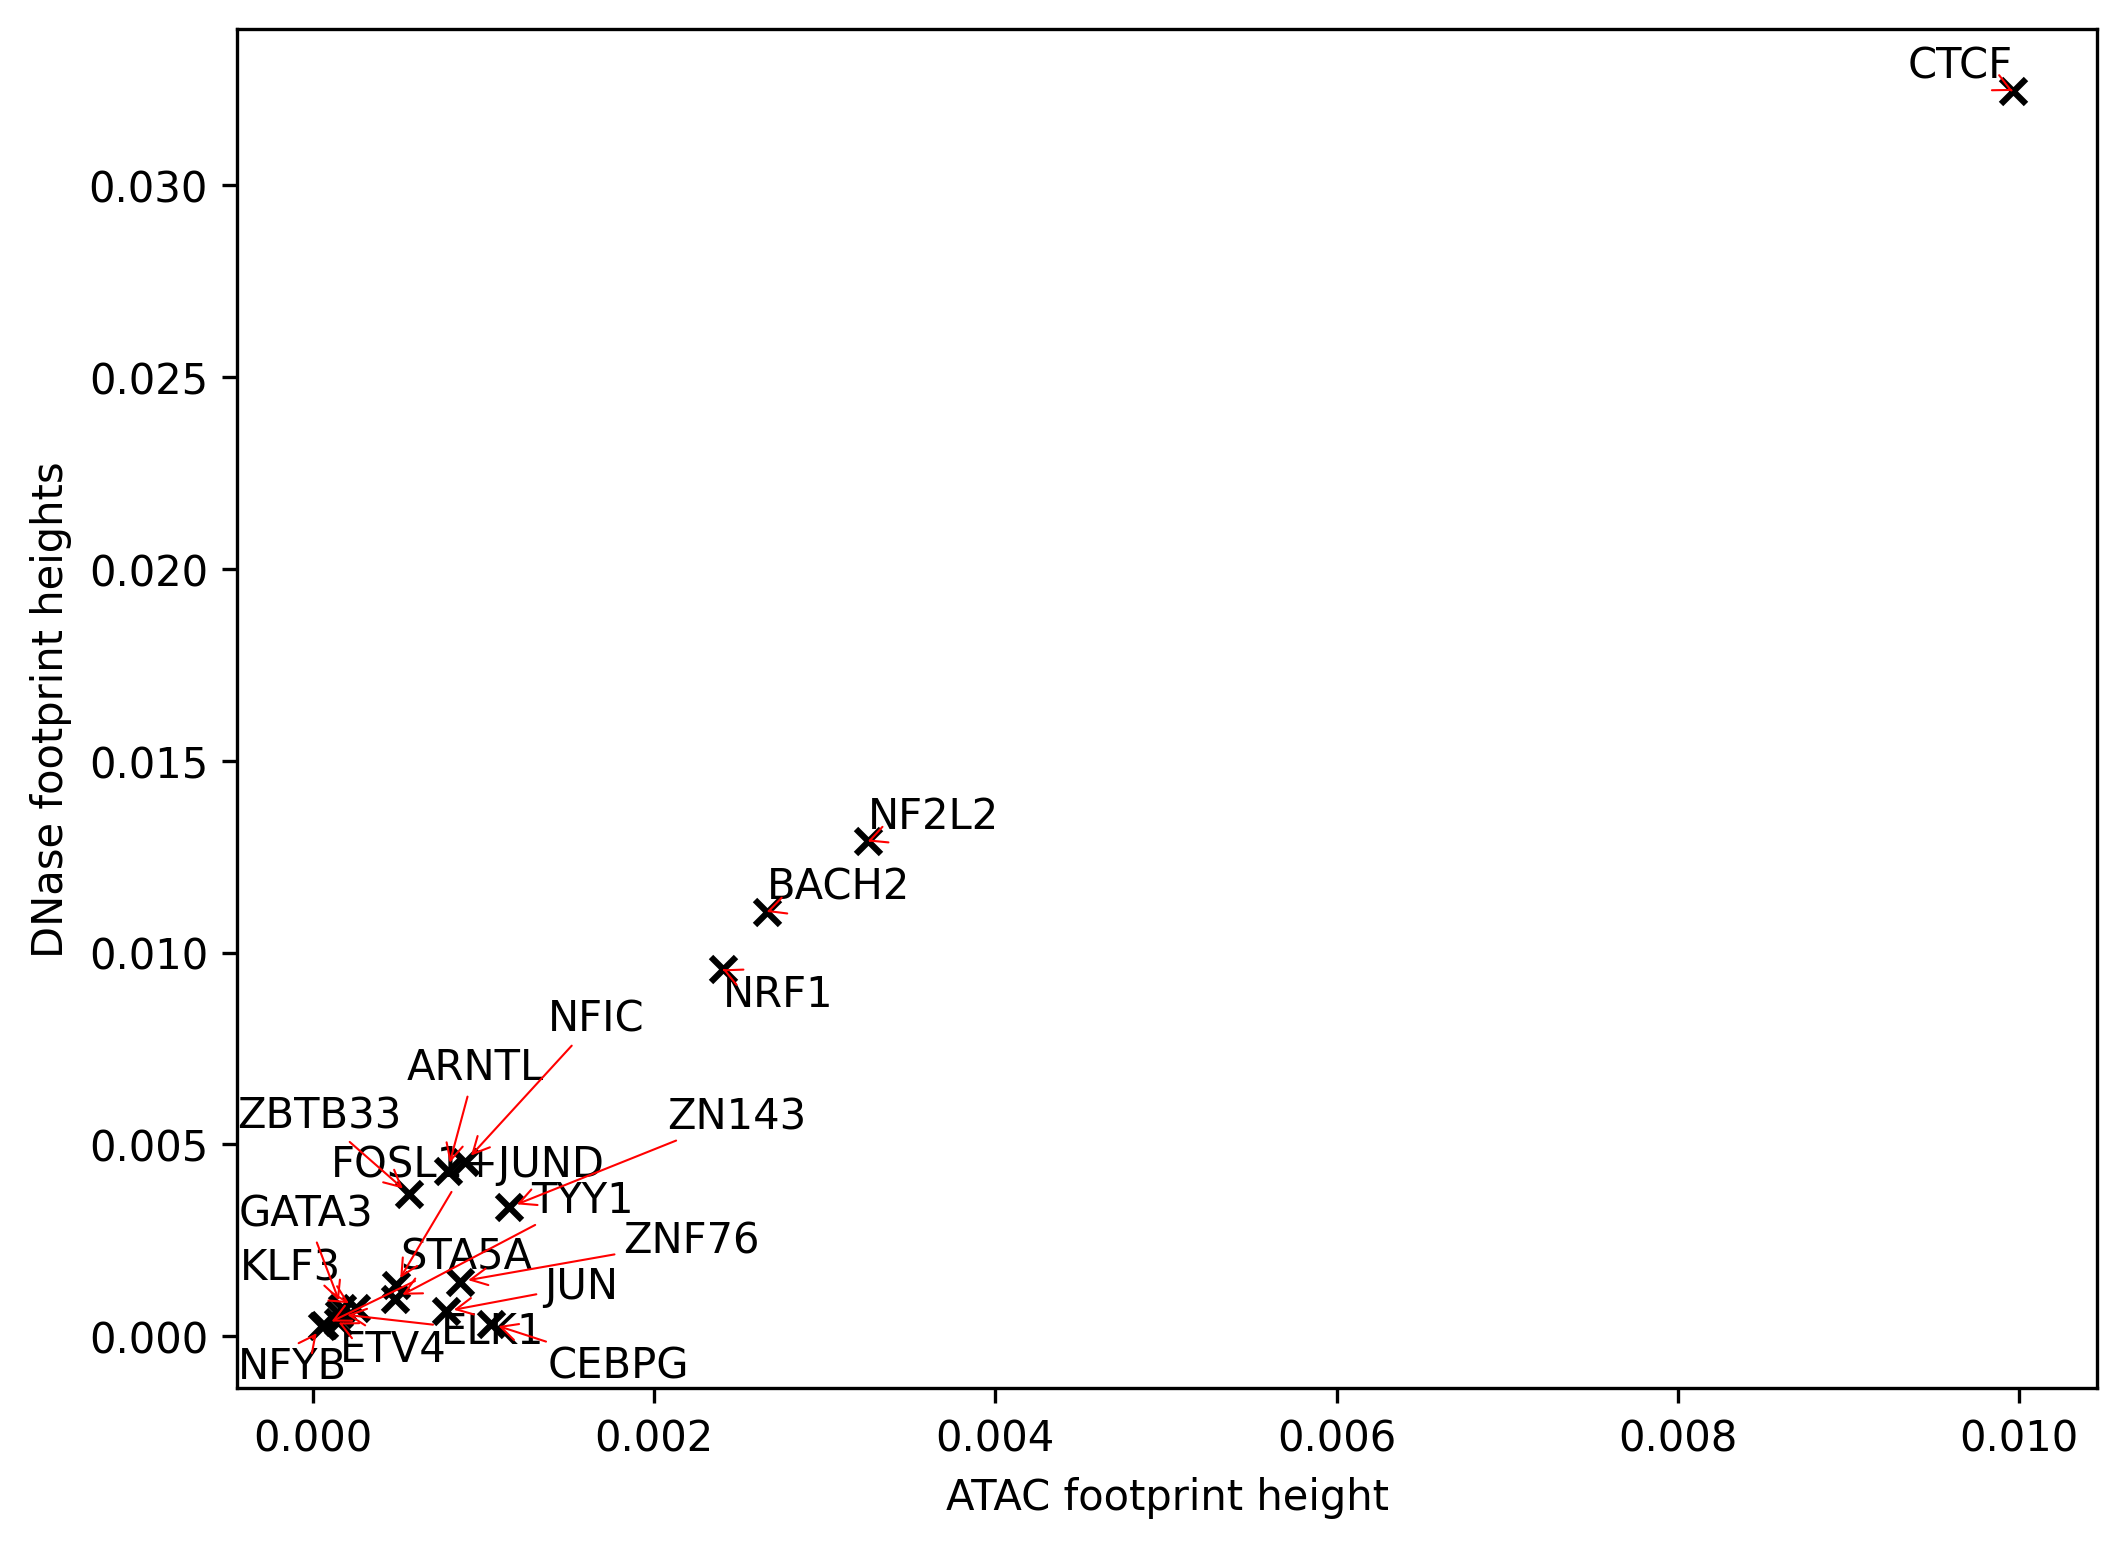

In [26]:
from adjustText import adjust_text

atac_vals = []
dnase_vals = []
motif_annotate = []
for motif in atac_height:
    print(motif)
#     if motif!="K562_COUNTS_metacluster_0_pattern_1":
#         continue
    atac_vals.append(atac_height[motif])
    dnase_vals.append(dnase_height[motif])
    motif_annotate.append(motif_names[motif])

plt.figure(figsize=(8, 6), dpi=300)

plt.scatter(atac_vals,dnase_vals, marker="x", c="black")
#plt.plot(atac_vals,atac_vals,alpha=0.5)
texts = []
for x, y, s in zip(atac_vals, dnase_vals, motif_annotate):
    texts.append(plt.text(x, y, s.split("_")[0]))

#for idx in range(len(atac_vals)):
#    plt.annotate(motif_annotate[idx].split("_")[0], (atac_vals[idx],dnase_vals[idx]))

#plt.yscale('log')
#plt.xscale('log')

plt.xlabel('ATAC footprint height')
plt.ylabel('DNase footprint heights') 
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
#plt.savefig("subfigs/footprints_compare/marginal_footprinting_height_2.pdf", dpi=300)

In [27]:

scipy.stats.pearsonr(atac_vals, dnase_vals)

(0.9828530952015504, 6.37662815002399e-14)

498

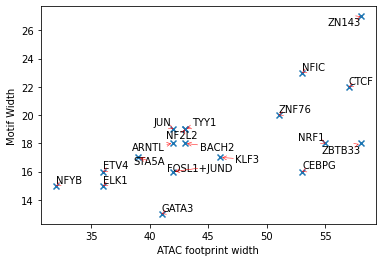

In [18]:
atac_vals = []
motif_vals = []
motif_annotate = []

for motif in atac_height:
    #if atac_height[motif] > 0.0005:
    atac_vals.append(atac_width[motif])
    motif_vals.append(motif_widths[motif])
    motif_annotate.append(motif_names[motif])

plt.scatter(atac_vals,motif_vals, marker="x")
texts = []
for x, y, s in zip(atac_vals, motif_vals, motif_annotate):
    texts.append(plt.text(x, y, s.split("_")[0]))

plt.xlabel('ATAC footprint width')
plt.ylabel('Motif Width') 
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
#plt.savefig("subfigs/footprints_compare/atac_footprint_width_versus_motif.pdf", dpi=300)


In [19]:
scipy.stats.pearsonr(atac_vals, motif_vals)

(0.6607388544669874, 0.0020722774659076714)

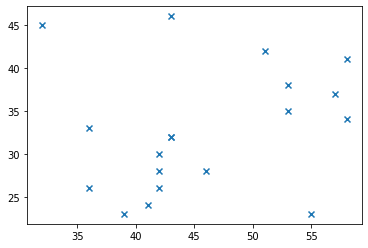

In [20]:
atac_vals = []
dnase_vals = []
motif_annotate = []

for motif in atac_width:
    atac_vals.append(atac_width[motif])
    dnase_vals.append(dnase_width[motif])
    motif_annotate.append(motif_names[motif])

plt.scatter(atac_vals,dnase_vals, marker="x")

In [70]:
#scipy.stats.pearsonr(atac_vals, motif_vals)

In [71]:
scipy.stats.pearsonr(dnase_vals, atac_vals)

(0.19063779812635, 0.43435116546634317)

In [81]:
df=pd.DataFrame({"width":atac_vals+dnase_vals, "data":["ATAC"]*len(atac_vals)+["DNASE"]*len(dnase_vals)})

In [82]:
df.to_csv("subfigs/footprints_compare/width.csv", index=False)